In [1]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import numpy as np

from typing import List
from scipy.optimize import curve_fit

In [2]:
warnings.filterwarnings('ignore')

# Power : KW
# Rmax/Rpeak : GFlops
# Energy efficiency : Gflops/Watts

In [3]:
# Some useful functions to:
## filter data:
def read_filter_top500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific top500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    file_path = f"data/TOP500_{y}{m}.xls{'x'*min(1, max(0, y-2019))}"
    df_f = pd.read_excel(
            file_path, 
            header=1 - min(1, max(0, y - 2007))
        )
    # truncating by range
    df_f = df_f.iloc[:range]

    # some data cleaning + scaling (Tflops to Gflops)
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y > 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y > 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000 
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))

    # choosing the fields of interest 
    df_f = df_f[fields]

    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    
    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/csv/TOP500_{y}{m}.csv')
    
    return df_f

def read_filter_green500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific Green500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    df_f = pd.read_excel(f"greendata/#green500_{y}_{m}.xlsx", header=0)

    # truncating by range
    df_f = df_f.iloc[:range]

    # homogenising the fields
    if y == 2014 and m == '06':
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
    elif y == 2015:
        df_f['TOP500 Rank'] = df_f['top500_rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
        df_f['Power'] = df_f['total_power']
    elif y == 2016 and m == '06' or (y == 2014 and m == '11'):
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
        df_f['Rank'] = df_f['Green500_Rank']
    elif y == 2016 and m == '11':
        df_f['TOP500 Rank'] = df_f['Rank']
        df_f['Rank'] = df_f['Green500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
    elif y < 2020:
        df_f['G_eff'] = df_f['Power Effeciency [GFlops/Watts]']
    elif y < 2022:
        df_f['G_eff'] = df_f['Power Efficiency [GFlops/Watts]']
    else:
        df_f['G_eff'] = df_f['Energy Efficiency [GFlops/Watts]']
    
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y> 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y >= 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
            df_f['Power'] = df_f['Power (kW)']
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))
    
    # choosing the fields of interest
    df_f = df_f[fields]
    
    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])

    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/csv/GREEN500_{y}{m}.csv')

    return df_f


## calculate apparitions:
def calc_apparition(l: List, unit: str = 'y'):
    """Calculates the apparition time of an HPC in the top500 list by years/months.
    
    Args:
        l (list): the list of apparition dates.
        unit (str): output unit.
        
    Returns:
        the apparition time in the chosen unit.
    """
    c = 0
    dates = []
    for el in l:
        if el[1] in dates:
            l.remove(el)
            continue
        dates.append(el[1])
        c+=1

    # return the apparition time 
    if unit == 'y':
        return c * 6 / 12

    return c

## calculate other values ...
def exp_funct(x: float, a: float, b: float):
    """Calculates the exp."""
    return a * np.power(np.exp(x), b)

def moore_funct(x: float, df: pd.DataFrame, metric: str = "RMax"):
    """Calculates moore's prediction."""
    return df.iloc[0][metric] * 2 ** (x/4)

def koomey_funct(x: float, df: pd.DataFrame, y: float = 0, metric: str = "G_eff"):
    """Calculates koomey's prediction."""
    return df.iloc[y][metric] * 2 ** ((x-y)/3)


In [4]:
# Our fields of interest.
main_fields = ['Computer', 'Year', 'Country', 'Cores', 'Rank', 'Site', 'RMax', 'RPeak']
main_green_fields = ['Computer', 'Year', 'Country', 'Cores', 'Site', 'Power',
                     'RMax', 'RPeak', 'TOP500 Rank', 'Rank', 'Accelerator/Co-Processor', 'G_eff']
# concatenate all the extracted dataframes into one single one from the year 1993 to 2023.
concat_df = pd.concat(
        [read_filter_top500_data(y, m, range=500, fields=main_fields) 
        for y in range(1994, 2023) for m in ['06', '11']], ignore_index=True
    )

green_concat_df = pd.concat(
        [read_filter_green500_data(y, m, range=100, fields=main_green_fields) 
        for y in range(2014, 2023) for m in ['06', '11']], ignore_index=True
    )

# some info about the concatenated dataframe
concat_df.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [5]:
# adding a minimum rank column.
tmp_fields = list(main_fields)
tmp_fields.remove('Rank')

concat_df['min_rank'] = concat_df[main_fields].groupby(tmp_fields).transform('min')
green_concat_df['g_min_rank'] = green_concat_df[tmp_fields + ['TOP500 Rank']].groupby(tmp_fields).transform('min')

# visualizing the output
concat_df.tail()


,Computer,Year,Country,Cores,Rank,Site,RMax,RPeak,rank_year,min_rank
28995,"Sugon TC6000, Xeon Gold 5118 12C 2.3GHz, 10G E...",2018,China,97920,496,Telecom Operator (C),1736000.0,7206912.0,2022-11,306
28996,"ThinkSystem Flex SN550, Xeon Gold 6150 18C 2.7...",2018,China,32400,497,Government,1735660.0,2799360.0,2022-11,117
28997,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,498,Internet Service A,1729000.0,3072000.0,2022-11,95
28998,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,499,Internet Service A,1729000.0,3072000.0,2022-11,95
28999,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,500,Internet Service A,1729000.0,3072000.0,2022-11,95


Avg shelflife: 1.40 | Max shelflife: 11.50 | Min shelflife: 0.50.  [+/- 0->6 months]


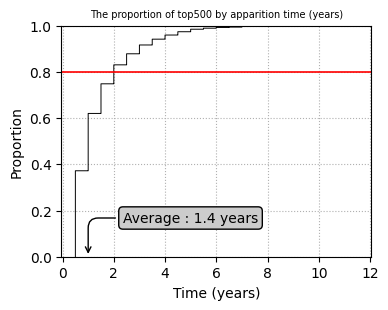

In [6]:
# plotting: The proportion of top500 by apparition time (years)
## plot settings
offset = 50
plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted')
plt.title('The proportion of top500 by apparition time (years)', fontsize=7)

## data reformatting
g_df = concat_df.copy(deep=True)
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# plotting the data
ax = sns.ecdfplot(data=g_df.reset_index()['rank_year'].apply(calc_apparition), color='black', linewidth=0.7)

# axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Proportion')

# Apparition time [mean, max, min]
minimum, average, maximum = g_df.apply(calc_apparition).min(), g_df.apply(calc_apparition).mean(), g_df.apply(calc_apparition).max()
print(
    "Avg shelflife: {0:.2f} | Max shelflife: {1:.2f} | Min shelflife: {2:.2f}.  [+/- 0->6 months]".format(
        average,
        maximum,
        minimum
        )
    )

# addiung an arrow to point out the average
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.annotate(
        f'Average : {average:.1f} years',
        xy=(1, 0), 
        xytext=(0.5*offset, 0.5*offset), textcoords='offset points',
        bbox=dict(boxstyle="round", fc="0.8"), arrowprops=arrowprops
    )

# highlighting the 80% proportion threshold
plt.axhline(y = 0.8, color = 'r', linewidth=1.2)


Text(9.426826714409723, 0.5, 'Performance (GFlops)')

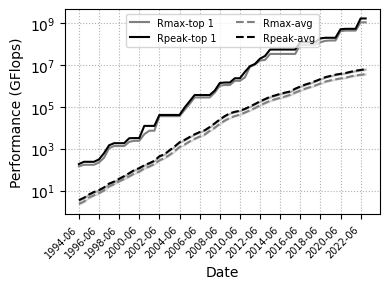

In [7]:
# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
plt.figure(figsize=(4, 3))
plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = concat_df[concat_df.Rank == 1]
log_df_mean = concat_df[concat_df.min_rank <= 500]

## The top1 plots
ax = sns.lineplot(data=log_df_max, x='rank_year', y='RMax', label='Rmax-top 1', markers=True, color='grey')
sns.lineplot(data=log_df_max, x='rank_year', y='RPeak', label='Rpeak-top 1', markers=True, color='black')

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='RMax', label='Rmax-avg', markers=True, color='grey', linestyle='--')
sns.lineplot(data=log_df_mean, x='rank_year', y='RPeak', label='Rpeak-avg', markers=True, color='black', linestyle='--')

## Layout
plt.legend(ncol=2, loc=9, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=4.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_ylabel('Performance (GFlops)')


Text(9.364326714409723, 0.5, 'GFlops')

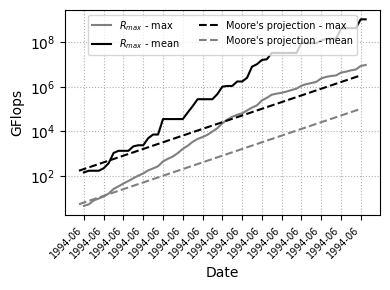

In [8]:
# Plotting : The maximum (and mean) Rmax Evolution of the Top500 supercomputers over time, along with Moore’s law projections
## plot settings
plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted') 
plt.yscale('log')

## mean & max df
log_df = concat_df.copy(deep=True)
log_df_mean = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()
log_df_mean['index'] = log_df_max.index + 1
log_df_max['index'] = log_df_mean.index + 1

## The mean and maximum plots of the Rmax value over time
sns.lineplot(data=log_df_mean, x='index', y='RMax', label=r'$R_{max}$ - max', color='grey')
sns.lineplot(data=log_df_max, x='index', y='RMax', label=r'$R_{max}$ - mean', color='black')

## Curve fitting the maximum and mean Rmax values 
popt_max, _ = curve_fit(exp_funct, list(log_df_max['index'])[:40], list(log_df_max.RMax)[:40])
popt_mean, _ = curve_fit(exp_funct, list(log_df_mean['index'])[:40], list(log_df_mean.RMax)[:40])

## Plotting moore's projections 
plt.plot(
        [x for x in list(log_df_max.index)], [moore_funct(x, log_df_max) for x in list(log_df_max['index'])], 'g-', 
        label="Moore's projection - max".format(*popt_max), ls='dashed', color='black'
    )
plt.plot(
        [x for x in list(log_df_mean.index)], [moore_funct(x, log_df_mean) for x in list(log_df_mean['index'])], 'g-', 
        label="Moore's projection - mean".format(*popt_mean), ls='dashed', color='grey'
    )

# Axis settings
plt.legend(ncol=2, loc=9,fontsize='7')
plt.xticks(
        rotation=45, ha='right', fontsize=7,ticks=np.arange(1, max(list(log_df_max['index'])), 4),
        labels=[list(log_df.rank_year)[i] for i in np.arange(1, max(list(log_df_max['index'])), 4)]
    )
plt.tight_layout()
plt.xlabel(r'Date')
plt.ylabel(r'GFlops')


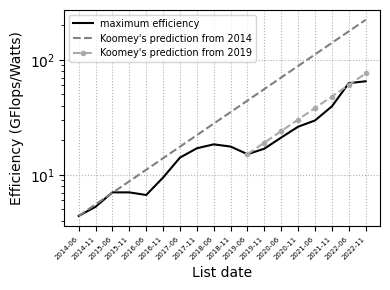

In [9]:

plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted') 

green_log_df = green_concat_df.copy(deep=True)
green_log_df_max = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max()

tmp = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max().reset_index()


sns.lineplot(data=green_log_df_max, x='rank_year', y='G_eff', label='maximum efficiency', color='black')

plt.plot(list(tmp.rank_year), [koomey_funct(x, df=tmp, metric='G_eff') for x in list(tmp.index)], 'g-', 
         label="Koomey's prediction from 2014".format(*popt_max), ls='dashed', color='grey')
plt.plot(list(tmp.rank_year[10:]), [koomey_funct(x, df=tmp, y=10, metric='G_eff') for x in list(tmp.index)[10:]], 'g.-', 
         label="Koomey's prediction from 2019".format(*popt_max), ls='dashed', color='darkgrey')


plt.yscale('log')
plt.xlabel(r'List date')
plt.ylabel(r'Efficiency (GFlops/Watts)')
plt.xticks(rotation=45, ha='right', fontsize=5)


ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0))


plt.legend(ncol=1, loc=2, fontsize=7)
plt.tight_layout()


In [10]:
green_concat_df['Accelerator/Co-Processor'] = list(green_concat_df['Accelerator/Co-Processor'].notnull().astype('int'))
green_concat_df

,Computer,Year,Country,Cores,Site,Power,RMax,RPeak,TOP500 Rank,Rank,Accelerator/Co-Processor,G_eff,rank_year,g_min_rank
0,"LX 1U-4GPU/104Re-1G Cluster, Intel Xeon E5-262...",2013,Japan,2720,"GSIC Center, Tokyo Institute of Technology",34.5800,151800.0,217824.0,437,1,1,4.389821,2014-06,437
1,"Dell T620 Cluster, Intel Xeon E5-2630v2 6C 2.6...",2013,United Kingdom,5120,Cambridge University,52.6176,191100.0,367565.0,201,2,1,3.631865,2014-06,201
2,"Cray 3623G4-SM Cluster, Intel Xeon E5-2680v2 1...",2013,Japan,4864,"Center for Computational Sciences, University ...",78.7700,277100.0,364288.0,165,3,1,3.517837,2014-06,165
3,"Bullx B515 cluster, Intel Xeon E5-2450v2 8C 2....",2014,Netherlands,3036,SURFsara,44.4000,153600.0,209880.0,421,4,1,3.459459,2014-06,421
4,"Cray XC30, Xeon E5-2670 8C 2.600GHz, Aries int...",2012,Switzerland,115984,Swiss National Supercomputing Centre (CSCS),1753.6600,5587000.0,7788852.8,6,5,1,3.185908,2014-06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,"BullSequana XH2000, AMD EPYC 7763 64C 2.45GHz,...",2021,France,810240,Commissariat a l'Energie Atomique (CEA),4959.4700,23237600.0,31761400.0,20,96,0,4.685501,2022-11,14
1796,"Bull Sequana XH2000 , AMD EPYC 7742 64C 2.25GH...",2020,France,294912,Meteo France,1655.0000,7683360.0,10469376.0,78,97,0,4.642514,2022-11,34
1797,"MEGWARE MiriQuid, Intel Xeon Platinum 9242 48C...",2020,Germany,59136,Technische Universitaet Darmstadt,690.0000,3148380.0,4352410.0,187,98,0,4.562870,2022-11,100
1798,"Bull Sequana X1000, Xeon Platinum 8168 24C 2.7...",2018,Germany,114480,Forschungszentrum Juelich (FZJ),1361.0000,6177730.0,9891072.0,93,99,0,4.539111,2022-11,23


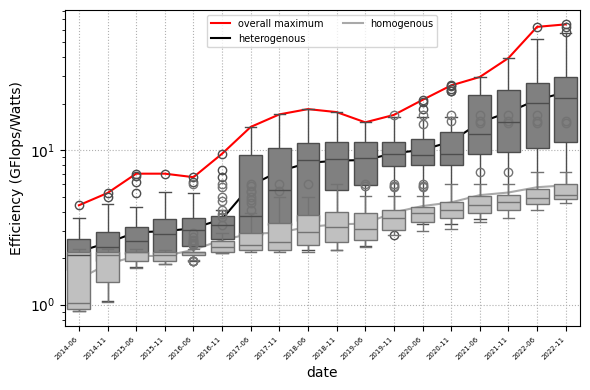

In [11]:
plt.figure(figsize=(6, 4))

g_gpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 1]
g_cpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 0]


sns.lineplot(data=green_concat_df.groupby('rank_year').max(), x='rank_year', y='G_eff', label='overall maximum', color='red')
sns.lineplot(data=g_gpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='heterogenous', color='black')
sns.lineplot(data=g_cpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='homogenous', color='darkgray')

sns.boxplot(data=g_gpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='gray')
sns.boxplot(data=g_cpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='silver')


plt.yscale('log')
plt.xlabel(r'date')
plt.ylabel(r'Efficiency (GFlops/Watts)')
plt.grid(linestyle='dotted') 
plt.legend(ncol=2, loc=9)


plt.xticks(rotation=45, ha='right', fontsize=5)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0))

plt.legend(ncol=2, loc=9, fontsize=7)
plt.tight_layout()


In [12]:
green_concat_df

,Computer,Year,Country,Cores,Site,Power,RMax,RPeak,TOP500 Rank,Rank,Accelerator/Co-Processor,G_eff,rank_year,g_min_rank
0,"LX 1U-4GPU/104Re-1G Cluster, Intel Xeon E5-262...",2013,Japan,2720,"GSIC Center, Tokyo Institute of Technology",34.5800,151800.0,217824.0,437,1,1,4.389821,2014-06,437
1,"Dell T620 Cluster, Intel Xeon E5-2630v2 6C 2.6...",2013,United Kingdom,5120,Cambridge University,52.6176,191100.0,367565.0,201,2,1,3.631865,2014-06,201
2,"Cray 3623G4-SM Cluster, Intel Xeon E5-2680v2 1...",2013,Japan,4864,"Center for Computational Sciences, University ...",78.7700,277100.0,364288.0,165,3,1,3.517837,2014-06,165
3,"Bullx B515 cluster, Intel Xeon E5-2450v2 8C 2....",2014,Netherlands,3036,SURFsara,44.4000,153600.0,209880.0,421,4,1,3.459459,2014-06,421
4,"Cray XC30, Xeon E5-2670 8C 2.600GHz, Aries int...",2012,Switzerland,115984,Swiss National Supercomputing Centre (CSCS),1753.6600,5587000.0,7788852.8,6,5,1,3.185908,2014-06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,"BullSequana XH2000, AMD EPYC 7763 64C 2.45GHz,...",2021,France,810240,Commissariat a l'Energie Atomique (CEA),4959.4700,23237600.0,31761400.0,20,96,0,4.685501,2022-11,14
1796,"Bull Sequana XH2000 , AMD EPYC 7742 64C 2.25GH...",2020,France,294912,Meteo France,1655.0000,7683360.0,10469376.0,78,97,0,4.642514,2022-11,34
1797,"MEGWARE MiriQuid, Intel Xeon Platinum 9242 48C...",2020,Germany,59136,Technische Universitaet Darmstadt,690.0000,3148380.0,4352410.0,187,98,0,4.562870,2022-11,100
1798,"Bull Sequana X1000, Xeon Platinum 8168 24C 2.7...",2018,Germany,114480,Forschungszentrum Juelich (FZJ),1361.0000,6177730.0,9891072.0,93,99,0,4.539111,2022-11,23


In [13]:
carbon_df = pd.read_csv('carbon_intensity_by_country.csv')
carbon_df[carbon_df['Entity'] == 'France']
carbon_df['Country'] = carbon_df['Entity']


In [14]:
new_df = green_concat_df.copy(deep=True)

new_df = new_df.merge(carbon_df, on=['Year', 'Country'])

In [15]:
new_df

,Computer,Year,Country,Cores,Site,Power,RMax,RPeak,TOP500 Rank,Rank,Accelerator/Co-Processor,G_eff,rank_year,g_min_rank,Entity,Code,Carbon intensity of electricity - gCO2/kWh
0,"LX 1U-4GPU/104Re-1G Cluster, Intel Xeon E5-262...",2013,Japan,2720,"GSIC Center, Tokyo Institute of Technology",34.5800,151800.0,217824.0,437,1,1,4.389821,2014-06,437,Japan,JPN,578.684600
1,"Dell T620 Cluster, Intel Xeon E5-2630v2 6C 2.6...",2013,United Kingdom,5120,Cambridge University,52.6176,191100.0,367565.0,201,2,1,3.631865,2014-06,201,United Kingdom,GBR,460.952330
2,"Cray 3623G4-SM Cluster, Intel Xeon E5-2680v2 1...",2013,Japan,4864,"Center for Computational Sciences, University ...",78.7700,277100.0,364288.0,165,3,1,3.517837,2014-06,165,Japan,JPN,578.684600
3,"Bullx B515 cluster, Intel Xeon E5-2450v2 8C 2....",2014,Netherlands,3036,SURFsara,44.4000,153600.0,209880.0,421,4,1,3.459459,2014-06,421,Netherlands,NLD,535.264470
4,"Cray XC30, Xeon E5-2670 8C 2.600GHz, Aries int...",2012,Switzerland,115984,Swiss National Supercomputing Centre (CSCS),1753.6600,5587000.0,7788852.8,6,5,1,3.185908,2014-06,6,Switzerland,CHE,40.217236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,"BullSequana XH2000, AMD EPYC 7763 64C 2.45GHz,...",2021,France,810240,Commissariat a l'Energie Atomique (CEA),4959.4700,23237600.0,31761400.0,20,96,0,4.685501,2022-11,14,France,FRA,67.389810
1792,"Bull Sequana XH2000 , AMD EPYC 7742 64C 2.25GH...",2020,France,294912,Meteo France,1655.0000,7683360.0,10469376.0,78,97,0,4.642514,2022-11,34,France,FRA,67.387390
1793,"MEGWARE MiriQuid, Intel Xeon Platinum 9242 48C...",2020,Germany,59136,Technische Universitaet Darmstadt,690.0000,3148380.0,4352410.0,187,98,0,4.562870,2022-11,100,Germany,DEU,332.184700
1794,"Bull Sequana X1000, Xeon Platinum 8168 24C 2.7...",2018,Germany,114480,Forschungszentrum Juelich (FZJ),1361.0000,6177730.0,9891072.0,93,99,0,4.539111,2022-11,23,Germany,DEU,411.295530


In [16]:
new_df['electric_consumption (GWh)'] = new_df['Power'] / 1e6
new_df['Carbon footprint (TCO2)'] = new_df['Carbon intensity of electricity - gCO2/kWh'] * new_df['electric_consumption (GWh)']  # Kg co2 par GWh
new_df['GFlops/KgCO2'] = new_df['RMax'] / (new_df['Carbon footprint (TCO2)'] * 1000)

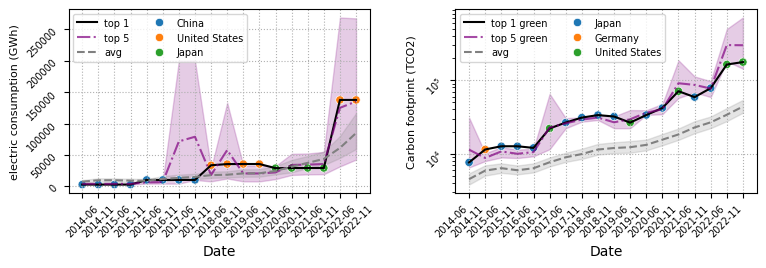

In [48]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
#plt.figure(figsize=(4, 3))
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 

plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = new_df[new_df['TOP500 Rank'] == 1]
log_df_5 = new_df[new_df['TOP500 Rank'] <= 5]
log_df_mean = new_df

g_log_df_max = new_df[new_df['Rank'] == 1]
g_log_df_5 = new_df[new_df['Rank'] <= 5]
g_log_df_mean = new_df

## The top1 plots
sns.lineplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1', markers=True, color='black', ax=ax[0])
sns.lineplot(data=log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[0])
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[0])


sns.lineplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1 green', markers=True, color='black', ax=ax[1])
sns.lineplot(data=g_log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5 green', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[1])
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
sns.lineplot(data=g_log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[1])
sns.scatterplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[1])


## Layout
plt.legend(ncol=2, loc=9, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

loc = plticker.MultipleLocator(base=1.0)

for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('', fontsize='9')
figure.subplots_adjust(top=0.88)
"""
## Axis settings
loc = plticker.MultipleLocator(base=4.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_ylabel('GFlops/KgCO2')
"""
plt.savefig('fig8')


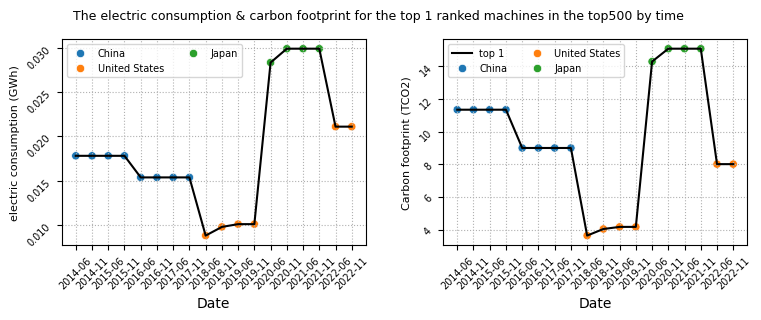

In [18]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = new_df[new_df['TOP500 Rank'] == 1]
log_df_mean = new_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top 1', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 1 ranked machines in the top500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('fig9')

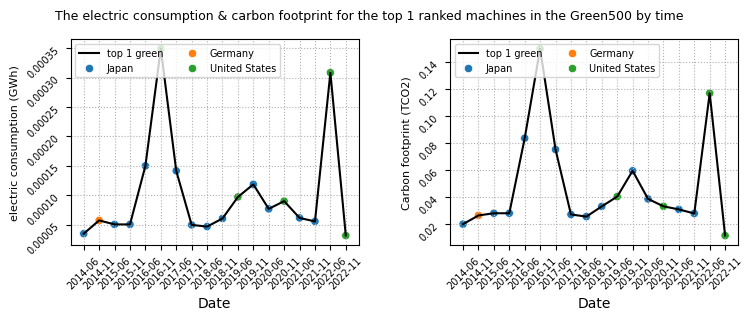

In [19]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = new_df[new_df['Rank'] == 1]
log_df_mean = new_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top 1 green', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top 1 green', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout


plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 1 ranked machines in the Green500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('green500_consumption.png')
plt.savefig('fig10')

Text(12.722222222222223, 0.5, 'Carbon footprint (TCO2)')

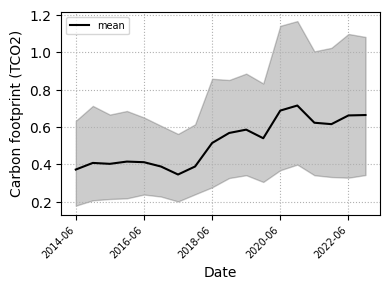

In [20]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
plt.figure(figsize=(4, 3))
#plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = new_df[new_df['TOP500 Rank'] == 1]
log_df_mean = new_df

## The top1 plots
ax = sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='mean', markers=True, color='black')
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')

## Layout
plt.legend(ncol=2, loc=2, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=4.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_ylabel('Carbon footprint (TCO2)')


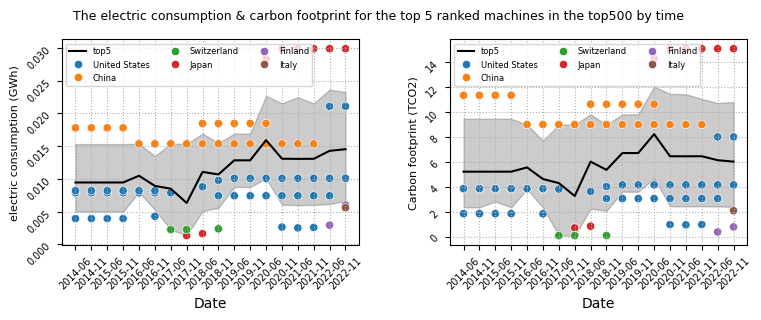

In [29]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = new_df[new_df['TOP500 Rank'] <= 5]
log_df_mean = new_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top5', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top5', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc=2, fontsize="6")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 5 ranked machines in the top500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('fig9')

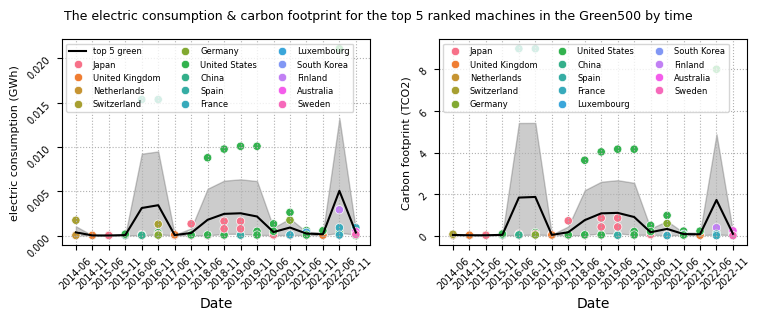

In [28]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = new_df[new_df['Rank'] <= 5]
log_df_mean = new_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top 5 green', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout


plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc=2, fontsize="6")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 5 ranked machines in the Green500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('green500_consumption.png')
plt.savefig('fig10')